In [2]:
import tensorflow as tf
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Conv3D, MaxPooling3D, Activation, Flatten, concatenate, Input
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time
from datetime import datetime
import math
from tqdm import tqdm
from PIL import Image

import modifiedTB as tb
from agent import Point

REPLAY_MEMORY_SIZE = 25_000
MIN_REPLAY_MEMORY_SIZE = 1_000
MODEL_NAME = "15"
MINIBATCH_SIZE = 64
DISCOUNT = 0.95
EPISODES = 25_000
MIN_REWARD = -1.00

epsilon = 0.5
EPSILON_DECAY = 0.9995
MIN_EPSILON = 0.001
LEARNING_RATE = 0.001
TAU = 0.97

AGGREGATE_STATS_EVERY = 25
SAVE_MODEL_EVERY = 200
SHOW_PREVIEW = False

SIZE = 10
N_BUILDINGS = 10
N_OBSTACLES = 0
MAX_HEIGHT = SIZE - 2
MOVE_PENALTY = 0.01
COLLISION_PENALTY = 0.25
GOAL_REWARD = 1.00
ACTION_SPACE_SIZE = 6
GROUND_PROX_PENALTY = 0.2

OBSERVATION_DIST = 3  # Change this: {1,2,3}
HETERO_REWARD = True  # Change this: {T(only when BINARY_ENV==F),F}
BINARY_ENV = False  # Change this: {T,F}

In [3]:
class TrainingEnv:
    def reset(self):
        self.terrain_map = self.generate_terrain()
        
        empty_blocks_iter = self.empty_blocks(self.terrain_map)
        self.agent = [Point(*next(empty_blocks_iter)), Point(*next(empty_blocks_iter))]
        self.drones_map = np.zeros((SIZE, SIZE, SIZE))
        self.goals_map = np.zeros((SIZE, SIZE, SIZE))
        self.drones_map[tuple(self.agent[0].location())] = 1
        self.goals_map[tuple(self.agent[1].location())] = 1
        self.dynamic_obs = [Point(*next(empty_blocks_iter)) for i in range(N_OBSTACLES)]
        self.obstacles_map = np.zeros((SIZE, SIZE, SIZE))
        for obs in self.dynamic_obs:
            self.obstacles_map[tuple(obs.location())] = 1
        
        # Keep track of the drone's trajectory
        self.path = [self.agent[0].location()]
            
        self.episode_step = 0
        
        return self.generate_state()

    def step(self, action):
        self.episode_step += 1
        done = False
        
        self.drones_map[tuple(self.agent[0].location())] = 0
        self.agent[0].action(action).within_bounds(SIZE,SIZE,SIZE)        
        self.drones_map[tuple(self.agent[0].location())] = 1
            
        self.path.append(self.agent[0].location())
        
        terrain = self.terrain_map == 1
        obstacles = self.obstacles_map == 1
        drones = self.drones_map == 1
        
        if (terrain|obstacles).astype(int)[tuple(self.agent[0].location())] == 1:
            reward = -COLLISION_PENALTY
            done = True
        elif self.agent[0] == self.agent[1]:
            reward = GOAL_REWARD
            done = True
        else:
            reward = (-MOVE_PENALTY) * (1.0 + (HETERO_REWARD * 2.0 * self.terrain_map[tuple(self.agent[0].location())]))
            
        for obs in self.dynamic_obs:
            self.obstacles_map[tuple(obs.location())] = 0
            obstacles = self.obstacles_map == 1
            while True:
                if not obs.drift().within_bounds(SIZE, SIZE, SIZE):
                    obs.drift_heading = 2 * np.random.rand(3) - 1
                if (terrain|obstacles|drones).astype(int)[tuple(obs.location())] != 1:
                    break
            self.obstacles_map[tuple(obs.location())] = 1
            obstacles = self.obstacles_map == 1
        
        new_observation = self.generate_state()

        if self.episode_step >= 100:
            done = True

        return new_observation, reward, done

    def render(self, elev=60, azim=45, save=""):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(elev=elev, azim=azim)
        ax.grid(True)
        
        terrain = self.terrain_map==1
        drones = self.drones_map==1
        goals = self.goals_map==1
        obstacles = self.obstacles_map==1
        
        voxelarr = terrain | drones | goals | obstacles
        colors = np.empty(terrain.shape, dtype=object)
        colors[terrain] = '#7A88CCC0'
        colors[drones] = '#FFD65DC0'
        colors[goals] = '#607D3BC0'
        colors[obstacles] = '#FDA4BAC0'
        ax.voxels(voxelarr, facecolors=colors, shade=True)
        
#         for action in range(len(self.path)-1):
#             xline = np.linspace(self.path[action][0] + 0.5, self.path[action+1][0] + 0.5, 1000)
#             yline = np.linspace(self.path[action][1] + 0.5, self.path[action+1][1] + 0.5, 1000)
#             zline = np.linspace(self.path[action][2] + 0.5, self.path[action+1][2] + 0.5, 1000)
#             ax.plot3D(xline, yline, zline, 'black')
        
        if save != "":
            plt.savefig(save)
        plt.show()
        

    def generate_terrain(self):
        terrain = np.zeros((SIZE, SIZE, SIZE))
        
        if GROUND_PROX_PENALTY and not BINARY_ENV:
            for i in range(SIZE//2):
                terrain[:,:,i] = GROUND_PROX_PENALTY * (SIZE // 2 - i)/(SIZE//2)
        
        for i in range(N_BUILDINGS):
            while True:
                # Generate random numbers in intervals of 0.5
                x, y = np.random.randint(0, SIZE*2, 2) / 2
                # Generate random building height
                z = np.random.randint(0, MAX_HEIGHT)
                # Check if existing buildings exist. If so, regenerate. Otherwise, keep building.
                if np.all(terrain[math.floor(x):math.ceil(x)+1, math.floor(y):math.ceil(y)+1, 0:z] != 1):
                    if not BINARY_ENV:
                        terrain[math.floor(x)-1:math.ceil(x)+2, math.floor(y)-1:math.ceil(y)+2, 0:z+1] \
                                = terrain[math.floor(x)-1:math.ceil(x)+2, math.floor(y)-1:math.ceil(y)+2, 0:z+1].clip(min=0.5)
                    terrain[math.floor(x):math.ceil(x)+1, math.floor(y):math.ceil(y)+1, 0:z].fill(1)
                    break
        return terrain
    
    def generate_state(self):
        x,y,z = tuple(self.agent[0].location())
        padded_terrain = np.pad(np.maximum(env.terrain_map, env.obstacles_map), OBSERVATION_DIST, 'constant', constant_values = 1)
        s = padded_terrain[x:x+1+2*OBSERVATION_DIST,y:y+1+2*OBSERVATION_DIST,z:z+1+2*OBSERVATION_DIST].flatten()
        return np.append(s, self.agent[0].vector(self.agent[1]))

    def empty_blocks(self, occupied):           
        empty_blocks = [[x,y,z] for x in range(SIZE) for y in range(SIZE) for z in range(SIZE) if occupied[x,y,z]!=1]
        random.shuffle(empty_blocks)
        return iter(empty_blocks)

In [2]:
env = TrainingEnv()

ep_rewards = [-1]

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

if not os.path.isdir('models'):
    os.makedirs('models')

NameError: name 'TrainingEnv' is not defined

In [4]:
class DQNAgent:
    def __init__(self, filepath=""):
        self.terrain_size = (1 + (2 * OBSERVATION_DIST)) ** 3
        if filepath == "":
            # Create primary model and target model
            self.model = self.create_model(self.terrain_size, 3, ACTION_SPACE_SIZE)
            self.target_model = self.create_model(self.terrain_size, 3, ACTION_SPACE_SIZE)
            self.target_model.set_weights(self.model.get_weights())
        else:
            # Load architecture and weights from model file
            self.model = keras.models.load_model(filepath)
            self.target_model = keras.models.load_model(filepath)

        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)
        
        cur_time = datetime.now().strftime("%m-%d_%H%M")
        self.tensorboard = tb.ModifiedTensorBoard(log_dir=f"logs/{MODEL_NAME}_{cur_time}")
        self.target_update_counter = 0
        
    def create_model(self, terrain_dim, goal_dim, output_dim):

        terrain_in = Input(shape=(terrain_dim))
        x = (Dense(128, activation='relu'))(terrain_in)
        x = (Dense(128, activation='relu'))(x)
        x = (Dense(128, activation='relu'))(x)
        
        x = (Dense(256, activation='relu'))(x)
        x = (Dense(256, activation='relu'))(x)
        x = (Dense(256, activation='relu'))(x)
        terrain_out = Dropout(0.1)(x)

        goal_in = Input(shape=(goal_dim))
        goal_out = (Dense(64, activation='relu'))(goal_in)
        
        concat = concatenate([terrain_out, goal_out])
        x = (Dense(256, activation='relu'))(concat)
        x = (Dense(256, activation='relu'))(x)
        x = (Dense(128, activation='relu'))(x)
        model_out = (Dense(output_dim, activation='linear'))(x)
        
        model = Model([terrain_in, goal_in], model_out)
        
        model.compile(loss=tf.keras.losses.Huber(), optimizer=Adam(learning_rate=LEARNING_RATE))
        
        return model
        
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)
    
    def get_qs(self, state):
        with tf.device('/GPU:0'):
            return self.model.predict(state)[0]

    def train(self, terminal_state, step):
        # Only train if there's sufficient replay memory size
        if len(self.replay_memory) >= MIN_REPLAY_MEMORY_SIZE:
            minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)
            
            current_states = [np.array([m[0][:self.terrain_size] for m in minibatch]), np.array([m[0][self.terrain_size:] for m in minibatch])]
            with tf.device('/GPU:0'):
                current_qs_list = self.model.predict(current_states)
            new_states = [np.array([m[3][:self.terrain_size] for m in minibatch]), np.array([m[3][self.terrain_size:] for m in minibatch])]
            with tf.device('/GPU:0'):
                future_qs_list = self.model.predict(new_states)
                future_qs_target_list = self.target_model.predict(new_states)

            X = current_states
            Y = []

            for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
                if not done:
                    future_q = future_qs_target_list[index][np.argmax(future_qs_list[index])]
                    new_q = reward + DISCOUNT * future_q
                else:
                    new_q = reward
                
                current_qs = current_qs_list[index]
                current_qs[action] = new_q

                Y.append(current_qs)
                
            with tf.device('/GPU:0'):
                self.model.fit(X, [np.array(Y)], batch_size = MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

            for t, e in zip(self.target_model.trainable_variables, self.model.trainable_variables):
                t.assign(t * TAU + (1-TAU) * e)

In [6]:
tf.autograph.set_verbosity(0)

agent = DQNAgent()

for episode in tqdm(range(1, EPISODES+1), ascii=True, unit="episode"):
    agent.tensorboard.step = episode

    episode_reward = 0
    step = 1
    current_state = env.reset()

    done = False

    while not done:
        if np.random.random() > epsilon:
            action = np.argmax(agent.get_qs([np.array([current_state[:agent.terrain_size]]), np.array([current_state[agent.terrain_size:]])]))
        else:
            action = np.random.randint(0, ACTION_SPACE_SIZE)
        
        new_state, reward, done = env.step(action)

        episode_reward += reward
        
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        
        agent.train(done, step)
        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)
        
    if not episode % SAVE_MODEL_EVERY and episode != 0:    
        # Save model
        agent.model.save(f'models/{MODEL_NAME}_{str(episode).zfill(5)}_{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)



  0%|                                                                                   | 0/25000 [00:01<?, ?episode/s]


KeyboardInterrupt: 

In [5]:
class TestEnv:
    def reset(self):
        self.terrain_map = self.generate_terrain()
        
        empty_blocks_iter = self.empty_blocks(self.terrain_map)
        self.agent = [Point(*next(empty_blocks_iter)), Point(*next(empty_blocks_iter))]
        self.drones_map = np.zeros((SIZE, SIZE, SIZE))
        self.goals_map = np.zeros((SIZE, SIZE, SIZE))
        self.drones_map[tuple(self.agent[0].location())] = 1
        self.goals_map[tuple(self.agent[1].location())] = 1
        self.dynamic_obs = [Point(*next(empty_blocks_iter)) for i in range(N_OBSTACLES)]
        self.obstacles_map = np.zeros((SIZE, SIZE, SIZE))
        for obs in self.dynamic_obs:
            self.obstacles_map[tuple(obs.location())] = 1
        
        # Keep track of the drone's trajectory
        self.path = [self.agent[0].location()]
            
        self.episode_step = 0
        
        return self.generate_state()

    def step(self):
        self.episode_step += 1
        done = False
        
        terrain = self.terrain_map == 1
        obstacles = self.obstacles_map == 1
        
        
        if np.random.rand() < 0.95:
            for i in range(ACTION_SPACE_SIZE):
                current_state = self.generate_state()
                action = np.argsort(agent.get_qs([np.array([current_state[:agent.terrain_size]]), np.array([current_state[agent.terrain_size:]])]))[-i-1]
                n = self.agent[0].copy().action(action)    
                n.within_bounds(SIZE, SIZE, SIZE)
                if (terrain|obstacles).astype(int)[tuple(n.location())] != 1:
                    break
        else:
            while True:
                action = np.random.randint(0, ACTION_SPACE_SIZE)
                n = self.agent[0].copy().action(action)    
                n.within_bounds(SIZE, SIZE, SIZE)
                if (terrain|obstacles).astype(int)[tuple(n.location())] != 1:
                    break
                    
        self.drones_map[tuple(self.agent[0].location())] = 0        
        self.agent[0].action(action).within_bounds(SIZE,SIZE,SIZE)        
        self.drones_map[tuple(self.agent[0].location())] = 1
            
        self.path.append(self.agent[0].location())
        
        terrain = self.terrain_map == 1
        obstacles = self.obstacles_map == 1
        drones = self.drones_map == 1
        
        if (terrain|obstacles).astype(int)[tuple(self.agent[0].location())] == 1:
            reward = -COLLISION_PENALTY
            done = True
        elif self.agent[0] == self.agent[1]:
            reward = GOAL_REWARD
            done = True
        else:
            reward = (-MOVE_PENALTY) * (1.0 + (HETERO_REWARD * 2.0 * self.terrain_map[tuple(self.agent[0].location())]))
            
        for obs in self.dynamic_obs:
            self.obstacles_map[tuple(obs.location())] = 0
            obstacles = self.obstacles_map == 1
            while True:
                if not obs.drift().within_bounds(SIZE, SIZE, SIZE):
                    obs.drift_heading = 2 * np.random.rand(3) - 1
                if (terrain|obstacles|drones).astype(int)[tuple(obs.location())] != 1:
                    break
            self.obstacles_map[tuple(obs.location())] = 1
            obstacles = self.obstacles_map == 1
        
        new_observation = self.generate_state()

        if self.episode_step >= 100:
            done = True

        return new_observation, reward, done

    def render(self, elev=60, azim=45, save=""):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(elev=elev, azim=azim)
        ax.grid(True)
        
        terrain = self.terrain_map==1
        drones = self.drones_map==1
        goals = self.goals_map==1
        obstacles = self.obstacles_map==1
        
        voxelarr = terrain | drones | goals | obstacles
        colors = np.empty(terrain.shape, dtype=object)
        colors[terrain] = '#7A88CCC0'
        colors[drones] = '#FFD65DC0'
        colors[goals] = '#607D3BC0'
        colors[obstacles] = '#FDA4BAC0'
        ax.voxels(voxelarr, facecolors=colors, shade=True)
        
#         for action in range(len(self.path)-1):
#             xline = np.linspace(self.path[action][0] + 0.5, self.path[action+1][0] + 0.5, 1000)
#             yline = np.linspace(self.path[action][1] + 0.5, self.path[action+1][1] + 0.5, 1000)
#             zline = np.linspace(self.path[action][2] + 0.5, self.path[action+1][2] + 0.5, 1000)
#             ax.plot3D(xline, yline, zline, 'black')
        
        if save != "":
            plt.savefig(save)
        plt.show()
        

    def generate_terrain(self):
        terrain = np.zeros((SIZE, SIZE, SIZE))
        
        if GROUND_PROX_PENALTY and not BINARY_ENV:
            for i in range(SIZE//2):
                terrain[:,:,i] = GROUND_PROX_PENALTY * (SIZE // 2 - i)/(SIZE//2)
        
        for i in range(N_BUILDINGS):
            while True:
                # Generate random numbers in intervals of 0.5
                x, y = np.random.randint(0, SIZE*2, 2) / 2
                # Generate random building height
                z = np.random.randint(0, MAX_HEIGHT)
                # Check if existing buildings exist. If so, regenerate. Otherwise, keep building.
                if np.all(terrain[math.floor(x):math.ceil(x)+1, math.floor(y):math.ceil(y)+1, 0:z] != 1):
                    if not BINARY_ENV:
                        terrain[math.floor(x)-1:math.ceil(x)+2, math.floor(y)-1:math.ceil(y)+2, 0:z+1] \
                                = terrain[math.floor(x)-1:math.ceil(x)+2, math.floor(y)-1:math.ceil(y)+2, 0:z+1].clip(min=0.5)
                    terrain[math.floor(x):math.ceil(x)+1, math.floor(y):math.ceil(y)+1, 0:z].fill(1)
                    break
        return terrain
    
    def generate_state(self):
        x,y,z = tuple(self.agent[0].location())
        padded_terrain = np.pad(np.maximum(env.terrain_map, env.obstacles_map), OBSERVATION_DIST, 'constant', constant_values = 1)
        s = padded_terrain[x:x+1+2*OBSERVATION_DIST,y:y+1+2*OBSERVATION_DIST,z:z+1+2*OBSERVATION_DIST].flatten()
        return np.append(s, self.agent[0].vector(self.agent[1]))

    def empty_blocks(self, occupied):           
        empty_blocks = [[x,y,z] for x in range(SIZE) for y in range(SIZE) for z in range(SIZE) if occupied[x,y,z]!=1]
        random.shuffle(empty_blocks)
        return iter(empty_blocks)
    
    def copy(self):
        env_copy = TestEnv()
        
        env_copy.terrain_map = self.terrain_map.copy()
        env_copy.agent = [self.agent[0].copy(), self.agent[1].copy()]
        env_copy.drones_map = np.zeros((SIZE, SIZE, SIZE))
        env_copy.goals_map = np.zeros((SIZE, SIZE, SIZE))
        env_copy.drones_map[tuple(env_copy.agent[0].location())] = 1
        env_copy.goals_map[tuple(env_copy.agent[1].location())] = 1
        
        env_copy.dynamic_obs = [self.dynamic_obs[i].copy() for i in range(N_OBSTACLES)]
        env_copy.obstacles_map = np.zeros((SIZE, SIZE, SIZE))
        for obs in env_copy.dynamic_obs:
            env_copy.obstacles_map[tuple(obs.location())] = 1
        
        env_copy.path = [i.copy() for i in self.path]
        
        env_copy.episode_step = self.episode_step
        
        return env_copy
        

In [ ]:
import csv
import statistics
import seaborn as sns

ELECTRIC_COST = 0.172625
VOR_HR = 1.308
DELTA_X_M = 2
DELTA_T_S = 0.2
VELOCITY = DELTA_X_M/DELTA_T_S

log = [("13", 10, 10, 0 ,1),
      ("14", 10, 10, 0 ,2),
      ("15", 10, 10, 0 ,3),
      ("16", 10, 25, 0 ,1),
      ("17", 10, 25, 0 ,2),
      ("18", 10, 25, 0 ,3),
      ("19", 10, 25, 10 ,1),
      ("20", 10, 25, 10 ,2),
      ("21", 10, 25, 10 ,3),
      ("22", 20, 50, 25 ,1),
      ("23", 20, 50, 25 ,2),
      ("24", 20, 50, 25 ,3)]

model = ["13_10600____0.97max____0.87avg____0.12min.model",
        "14_14600____0.99max____0.80avg___-0.43min.model",
        "15_07200____0.99max____0.87avg____0.74min.model",
        "16_02600____0.97max____0.73avg___-1.06min.model",
        "17_03200____0.97max____0.65avg___-0.48min.model",
        "18_14000____0.98max____0.84avg___-0.26min.model",
        "19_04400____0.96max____0.79avg___-0.30min.model",
        "20_10000____1.00max____0.72avg___-0.29min.model",
        "21_22400____0.98max____0.64avg___-0.43min.model",
        "22_01200____0.58max___-0.58avg___-1.30min.model",
        "23_11200____0.88max___-0.00avg___-1.00min.model",
        "24_10400____0.94max____0.21avg___-1.06min.model"]

for idx, i in enumerate(log):

    MODEL_NAME, SIZE, N_BUILDINGS, N_OBSTACLES, OBSERVATION_DIST = i
   
    env = TestEnv()
    agent = DQNAgent("models/"+model[idx])

    N_TESTS = 1

    rewards = []
    lengths = []


    for ep in range(N_TESTS):

        episode_reward = 0
        step = 1

        current_state = env.reset()
        L1 = sum(abs(env.agent[0].location() - env.agent[1].location()))
        while L1 != SIZE:
            current_state = env.reset()
            L1 = sum(abs(env.agent[0].location() - env.agent[1].location()))

        done = False

        while not done:
            env.render(save=f"visualisations/{MODEL_NAME}_{step}.png")
            new_state, reward, done = env.step()
            episode_reward += reward
            current_state = new_state
            step += 1
        env.render(save=f"visualisations/{MODEL_NAME}_{step}.png")

        print(f"Model {MODEL_NAME}, Reward {episode_reward}, Length {step}")
        
#         rewards.append(episode_reward)
#         lengths.append(step)
        
        
#         if ep % 20 == 0:
#             print('.', end="")
#             if ep % 100 == 0:
#                 print()


#     with open(f'{MODEL_NAME}_test.csv', 'w', newline='') as file:
#         mywriter = csv.writer(file, delimiter=',')
#         for i in range(len(rewards)):
#             mywriter.writerow((rewards[i], lengths[i]))



#     avg_distance = statistics.mean([l for l in lengths if l != 101]) * DELTA_X_M
#     standard_dev = statistics.stdev([l for l in lengths if l != 101]) * DELTA_X_M
#     perc_90 = np.percentile([l for l in lengths if l != 101], 90)
#     perc_50 = np.percentile([l for l in lengths if l != 101], 50)

#     sns.set(palette="flare")
#     plt.hist([r for r in rewards if r > 0], density=True, bins=50)
#     plt.ylabel('Freq')
#     plt.xlabel('Reward')
#     plt.title(f"Run {MODEL_NAME}: Avg Reward = {sum(rewards)/len(rewards):.3f}")
#     plt.savefig(f"{MODEL_NAME}_reward.png", dpi=960)
#     plt.show()

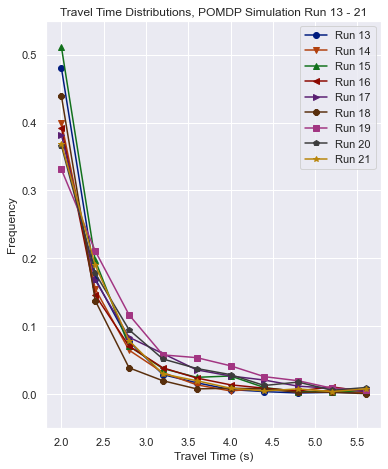

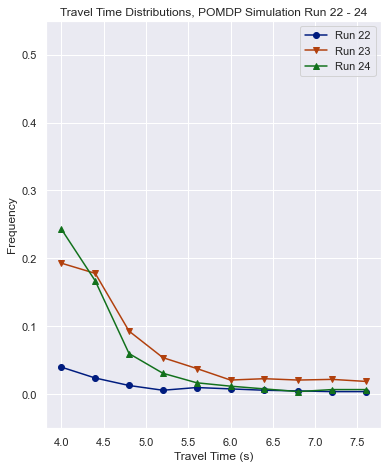

In [446]:
labels = [t/5 for t in range(10,30,2)]
sns.set(palette="dark")
plt.figure(figsize=(6,7.5))

m = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

for i in range(13,22):    
    
    rewards = []
    lengths = []
    with open(f'{i}_test.csv') as file:
        myreader = csv.reader(file)
        for j in myreader:
            rewards.append(float(j[0]))
            lengths.append(float(j[1]))

    values = [len([l for l in lengths if l == j or l == j+1])/1000 for j in range(11,31,2)]
    plt.plot(labels, values, '-'+m[i-13], label=f"Run {i}")

plt.ylabel('Frequency')
plt.ylim([-0.05,0.55])
plt.xlabel('Travel Time (s)')
plt.title(f"Travel Time Distributions, POMDP Simulation Run 13 - 21")
plt.legend()

plt.savefig(f"Combined_time_3.png", dpi=480)
plt.show()

labels = [t/5 for t in range(20,40,2)]
plt.figure(figsize=(6,7.5))

for i in range(22,25):    
    
    rewards = []
    lengths = []
    with open(f'{i}_test.csv') as file:
        myreader = csv.reader(file)
        for j in myreader:
            rewards.append(float(j[0]))
            lengths.append(float(j[1]))

    values = [len([l for l in lengths if l == j or l == j+1])/1000 for j in range(21,41,2)]
    plt.plot(labels, values, '-'+m[i-22], label=f"Run {i}")

plt.ylabel('Frequency')
plt.ylim([-0.05,0.55])
plt.xlabel('Travel Time (s)')
plt.title(f"Travel Time Distributions, POMDP Simulation Run 22 - 24")
plt.legend()

plt.savefig(f"Combined_time_4.png", dpi=480)
plt.show()

